# Use of FoKL-GPy's symbolic Gaussian process in improved fitting of Langmuir isotherm adsorption model parameters

---

## Background

The Langmuir isotherm is
$\theta_1 = \frac{q}{q_{max}} = \frac{\sigma_1 \mu}{1 + \sigma_1 \mu}$
where
$\mu = \frac{m}{M} = \frac{p}{\sqrt{2 \pi M R T}}$.

Rearranging,
$q = \frac{\sigma_1 q_{max} \mu}{1 + \sigma_1 \mu}$.

For varying pressure $p$ at constant temperature $T$, it is typically assumed that $\sigma_1$ is constant such that
$\sigma_1 \mu = a p$.

This assumption, together with $b \equiv q_{max}$, enable
$\frac{p}{q} = \frac{1}{b}p + \frac{1}{ab}$
which is just $y=mx+b$ such that a linear fit of measurements $q(p)$ provides constant values $a$ and $b$ at constant $T$.

---

## The Case for FoKL-GPy

Examining more closely reveals
$\sigma_1 \mu = \sigma_1 \frac{p}{\sqrt{2 \pi M R T}} \implies a = \frac{\sigma_1}{\sqrt{2 \pi M R T}}$.

Unless reaction rates $\alpha$ and $\nu_1$ are constant with respect to pressure, since $\sigma_1 = \frac{\alpha}{\nu_1}$, the typical assumption that $a$ is constant at $T$ may be improved with the modeling of a Gaussian process (GP). In other words, at constant $T$, assuming $a$ is constant is equivalent to assuming $\sigma_1$ is constant.

Examining the reaction rates as expressed in the relative life,
$\sigma_1 = \frac{\alpha}{\nu_1} = \frac{\exp(\Delta_f G / RT)}{\exp(\Delta_r G / RT)} = \exp(\frac{\Delta_f G - \Delta_r G}{RT})$.

Since Gibbs free energy $G$ is not independent of $p$, and therefore $\sigma_1$ is not constant at constant $T$, $\sigma_1$ may be more accurately modeled with a GP rather than linear fit. Furthermore, since a FoKL-GPy model may be embedded in Pyomo, additional chemistry constraints and an optimization objective may be included, though this is also possible with a linear Langmuir isotherm model.

---

## Outline of Method

Langmuir's mica experiment contains measurements of $q$ for varying $p$ at constant $T$. He conducted this experiment at $T=90\ \text{K}$ and again at $T=155\ \text{K}$. Note the improvement enabled by a GP exists even for data obtained at a single temperature, but variations due to temperature may be captured too since the data is available.

To ensure $\sigma_1$ is positive such that the model has physical meaning, the GP model will be trained on the exponent of $\sigma_1$ since the GP itself may not be constrained to positive values.

That is, the FoKL-GPy model at constant $T$ would be $\Delta \equiv \frac{\Delta_f G - \Delta_r G}{RT} = \ln(\sigma_1) \propto p$. However, since data is available at multiple temperatures, the model will be expanded to $\Delta \propto (T, p)$ for demonstration. With the data limited to only two temperatures, it is not expected for the GP to provide accurate predictions except near $T=90\ \text{K}$ or $T=155\ \text{K}$.

From the measurements, $\sigma_1$ must first be calculated. Recall $q = \frac{\sigma_1 q_{max} \mu}{1 + \sigma_1 \mu}$, which yields $\sigma_1 = \frac{q}{\mu(q_{max}-q)}$. If $q_{max}$ is known, then $\sigma_1$ may be solved for since $q$ is measured and $\mu$ is a known function of $(T, p)$. Therefore, $q_{max}$ must be modeled or measured in some way.

Taking $q_{max}$ to be the $b$ values from the linear fit as found by Langmuir, at least for this benchmark comparison, enables $\sigma_1$ to be calculated. Then, $\theta_1$ may be calculated. Note it is reasonable to assume $q_{max}$ is independent of $p$ since the driving force of the surface characteristics is $T$. So, despite $b$ being independent of $p$, there is no drawback. The place to improve here would be to measure or model $q_{max}$ in perhaps a more direct or accurate way. Measurements of $q$ after a long time, i.e., $\frac{\partial}{\partial t}(q) \approx 0$, could also provide values of $q_{max}$.

FoKL-GPy will model $\ln(\sigma_1)$ from Langmuir's data, then $\theta_1$ will be predicted. Scaling FoKL-GPy's $\theta_1$ by $b$ will enable a direct comparison with Langmuir's $q_{cal}$, since $\theta_1$ = q_{cal}/q_{max}$ and for demonstration $q_{max}=b$.

## Implementation of Method

Data from Langmuir's mica experiment, Tables II-VI and X, have been written to *txt* files *N2*, *CH4*, *CO*, *Ar*, and *O2*. For example, the *N2* dataset is as follows.

| $T$     | $p$     | $q_{obs}$ | $b$   | $q_{cal}$ |
|---------|---------|---------|---------|---------|
| 90      | 37.5    | 24.2    | 32.5    | 24.6    |
| "       | 25.7    | 22.7    | "       | 22.4    |
| "       | 4.04    | 7.55    | "       | 8.3     |
| "       | 2.8     | 6.8     | "       | 6.2     |
| 155     | 65.8    | 6.2     | 11.8    | 6.3     |
| "       | 37.5    | 4.8     | "       | 4.7     |
| "       | 3.9     | 0.43    | "       | 0.75    |
| "       | 2.2     | 0.43    | "       | 0.43    |

Note that to fill in values of $q$ for *CO*, *Ar*, and *O2*, where $q_{obs}$ is missing in the Tables, Equation 31 was used with $(p,a,b)$ values as listed in the Tables. Also note $q_{cal}$ is included for benchmark comparison, but is not used for the FoKL-GPy model.

Nomenclature:
| Langmuir | FoKL-GPy |
|---|---|
| $q_{obs}$ | $q \implies$ ```q``` |
| $b$ | $q_{max} \implies$ ```qmax``` |
| $q_{cal}$ | $q_{cal} \implies$ ```qcal``` |

---

Importing modules and defining constants:

In [3]:
import os
import sys
sys.path.append(os.path.join('..', '..', '..', '..'))  # include local path (i.e., this package)

from src.FoKL import FoKLRoutines
from src.FoKL import fokl_to_pyomo
import pyomo.environ as pyo
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt


gases = ['N2', 'CH4', 'CO', 'Ar', 'O2']
M = {'N2': 0.0280134, 'CH4': 0.01604246, 'CO': 0.0280101, 'Ar': 0.039948, 'O2': 0.0319988}  # molecular weight, kg / mol
R = 8.31446261815324  # universal gas constant, J / (K * mol)

/home/jacobpatrick/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Loading the data:

In [4]:
data = {}
for gas in gases:
    data.update({gas: np.loadtxt(os.path.join('data', f"{gas}.txt"), skiprows=1)})

FileNotFoundError: data/N2.txt not found.

Parsing the data and converting units to SI:

In [ ]:
T = {}
p = {}
q = {}
a = {}
qmax = {}  # = b
qcal = {}  # for benchmark comparison
for gas in gases:
    T.update({gas: data[gas][:, 0]})  # K
    p.update({gas: data[gas][:, 1] * 1e5})  # bars to Pa
    q.update({gas: data[gas][:, 2] * 1e-9})  # mm^3 to m^3
    a.update({gas: data[gas][:, 3] * 1e-5})  # 1/bars to 1/Pa
    qmax.update({gas: data[gas][:, 4] * 1e-9})  # mm^3 to m^3
    qcal.update({gas: data[gas][:, 5] * 1e-9})  # mm^3 to m^3

Calculating $mu$ and $sigma_1$:

In [ ]:
mu = {}
sigma1 = {}
for gas in gases:
    mu.update({gas: p[gas] /np.sqrt(2 * np.pi * M[gas] * R * T[gas])})
    sigma1.update({gas: q[gas] / mu[gas] / (qmax[gas] - q[gas])})

Initializing FoKL-GPy models with continuous basis functions, i.e., ```kernel=1```:

In [ ]:
def initialize_foKL_model():
    return FoKLRoutines.FoKL(kernel=1, tolerance=12, threshav=0.1, gimmie=True)

N2 = initialize_foKL_model()
CH4 = initialize_foKL_model()
CO = initialize_foKL_model()
Ar = initialize_foKL_model()
O2 = initialize_foKL_model()

models = [N2, CH4, CO, Ar, O2]

Train FoKL-GPy models on $\Delta \propto (T^{-1}, \ln(p))$:

In [ ]:
i = 0
Delta = {}
for gas in gases:
    print(f"\nTraining {gas}...")
    Delta.update({gas: np.log(sigma1[gas])})
    models[i].fit([1 / T[gas], np.log(p[gas])], Delta[gas], clean=True)
    i += 1


Training N2...


/home/jacobpatrick/FoKL-GPy/docs/_dev/langmuir_isotherm/../../../src/FoKL/FoKLRoutines.py:299: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


[1, -15.130113256172834]
[2, -15.130113256172834]
[2, -15.130113256172834]
[3, -15.130113256172834]
[3, -15.130113256172834]
[4, -15.130113256172834]
[4, -15.130113256172834]
[4, -15.53174008443462]
[5, -15.53174008443462]
[5, -15.53174008443462]
[5, -15.53174008443462]
[6, -15.53174008443462]
[6, -15.53174008443462]
[6, -15.632623916360401]
[6, -15.632623916360401]
[7, -24.686210667603348]
[7, -324.6169770517062]
[7, -324.6169770517062]
[7, -324.6169770517062]
[8, -324.6169770517062]
[8, -103.27573609525669]
[8, -75.40463534906792]
[8, -75.40463534906792]
[8, -43.95745226356256]
[9, -43.95745226356256]
[9, -40.33752069479722]
[9, -33.72363367932218]
[9, -39.340474753496]
[9, -39.340474753496]

Training CH4...
[1, -8.301225371591523]
[2, -8.301225371591523]
[2, -8.301225371591523]
[3, -8.301225371591523]
[3, -8.301225371591523]
[4, -8.301225371591523]
[4, -8.301225371591523]
[4, -8.301225371591523]
[5, -8.301225371591523]
[5, -8.301225371591523]
[5, -8.301225371591523]
[6, -8.301225371

/home/jacobpatrick/.local/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[2, -23.457391223424942]
[3, -22.92882849400899]
[3, -372.0697064609567]
[4, -372.0697064609567]
[4, -372.0697064609567]
[4, -372.0697064609567]
[5, -372.0697064609567]
[5, -372.0697064609567]
[5, -372.0697064609567]
[6, -372.0697064609567]
[6, -372.0697064609567]
[6, -372.0697064609567]
[6, -287.81720729544963]
[7, 25.730577052023655]
[7, 28.53699957598275]


Plot curve fits (linear vs. GP):

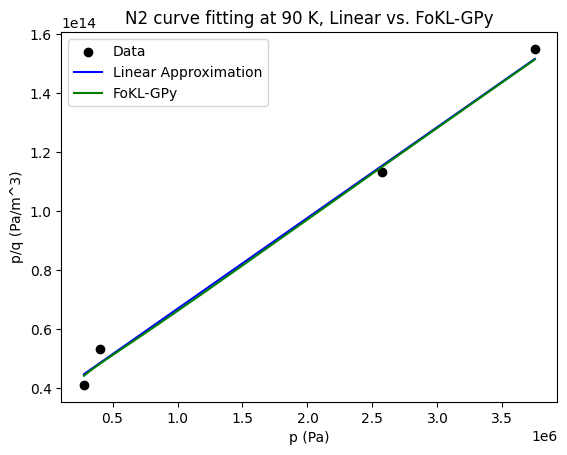

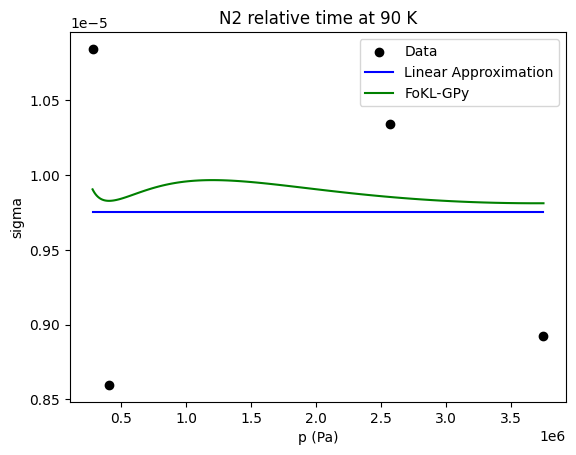

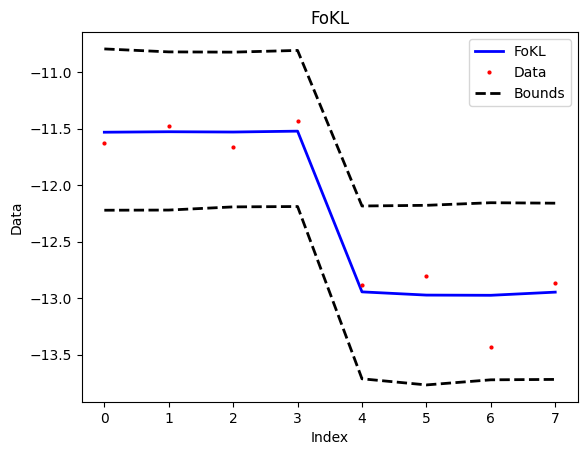

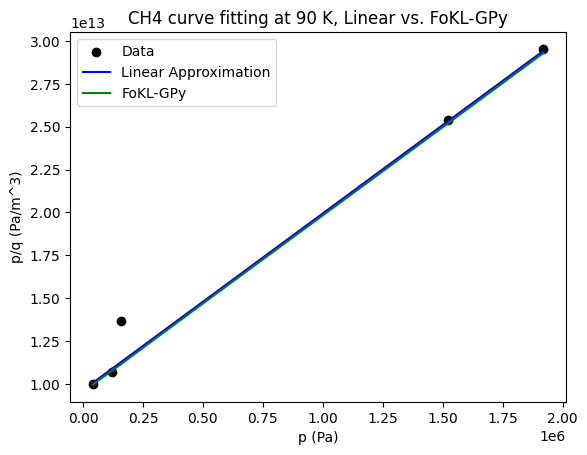

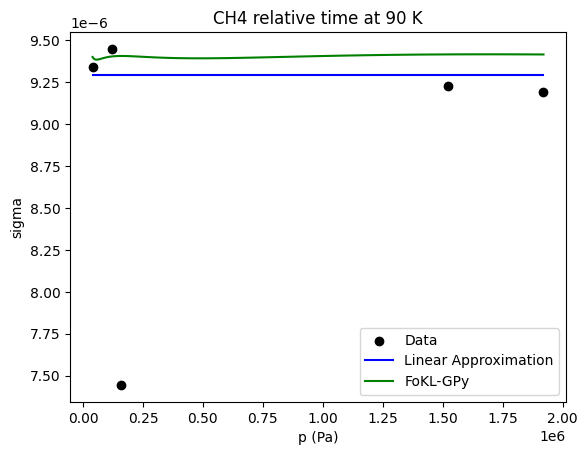

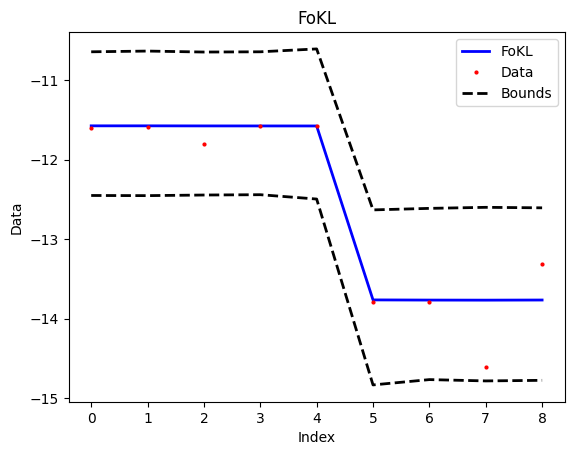

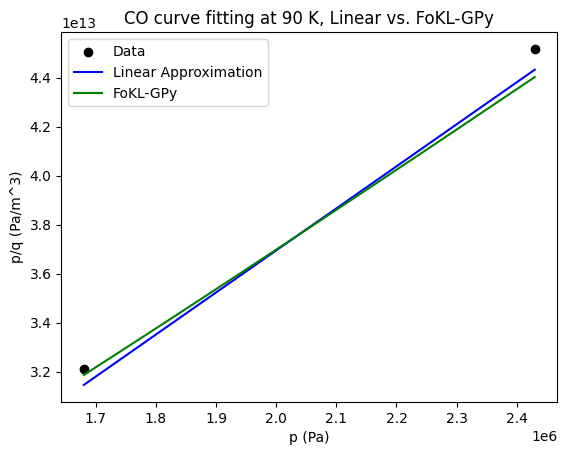

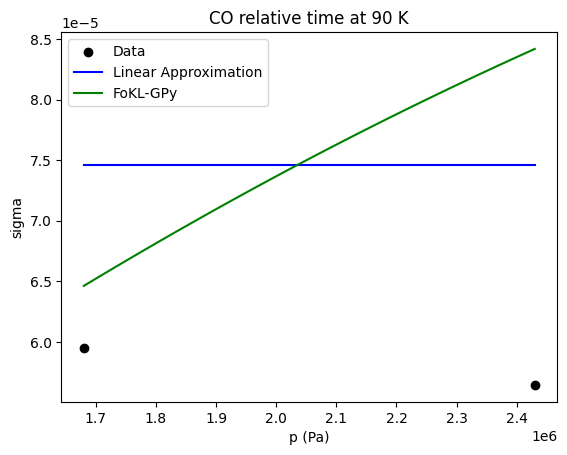

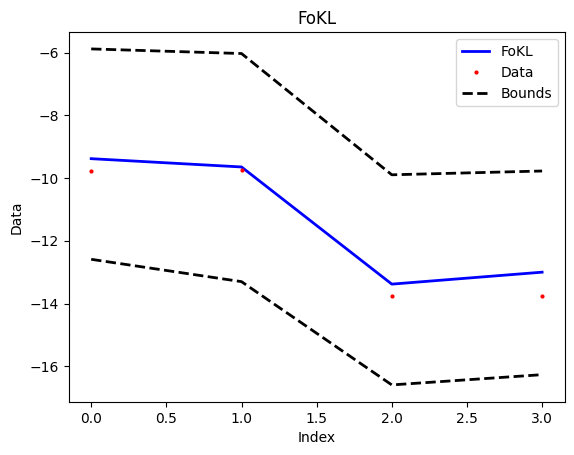

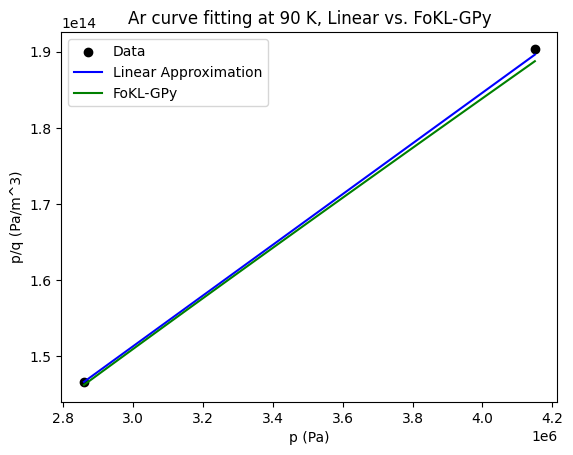

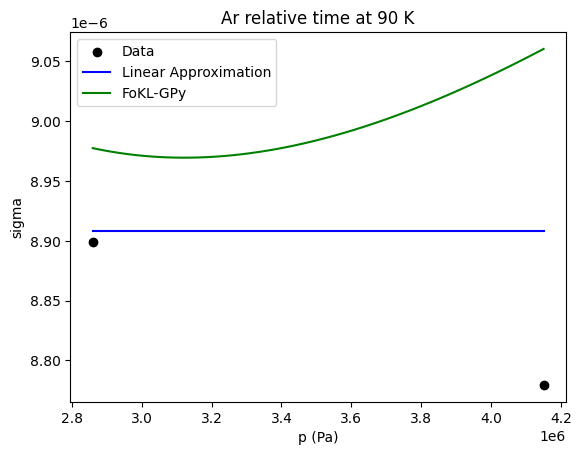

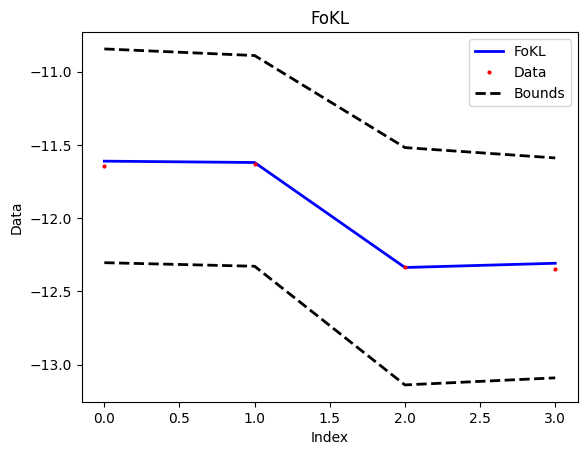

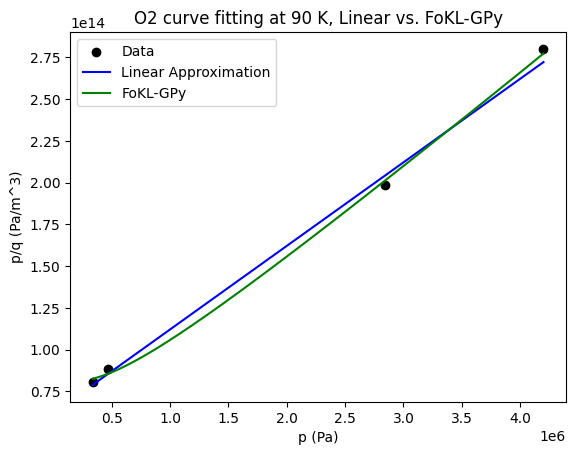

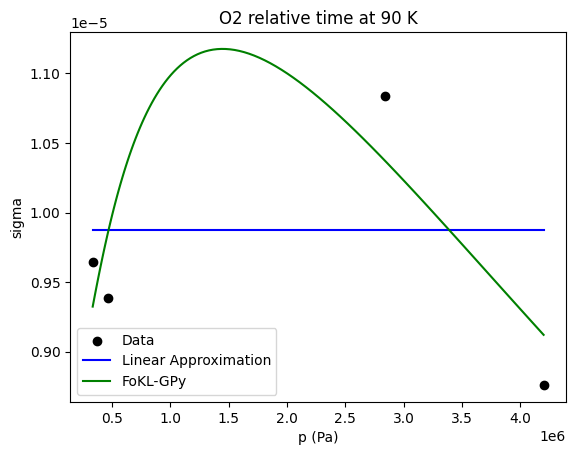

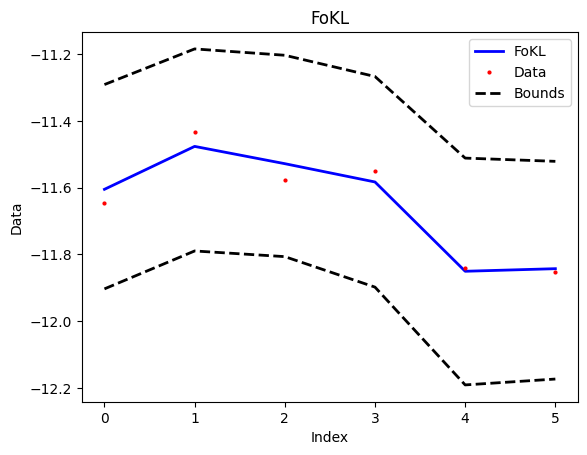

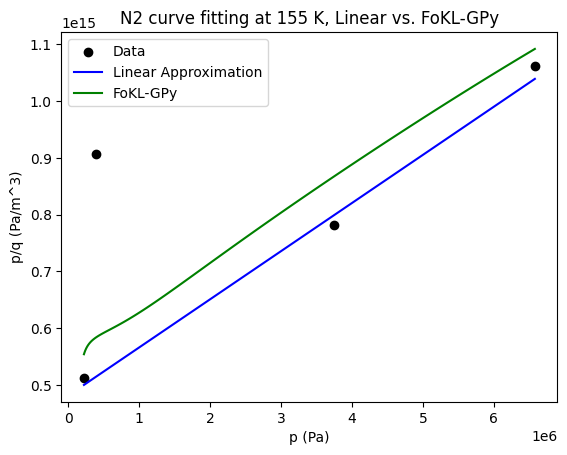

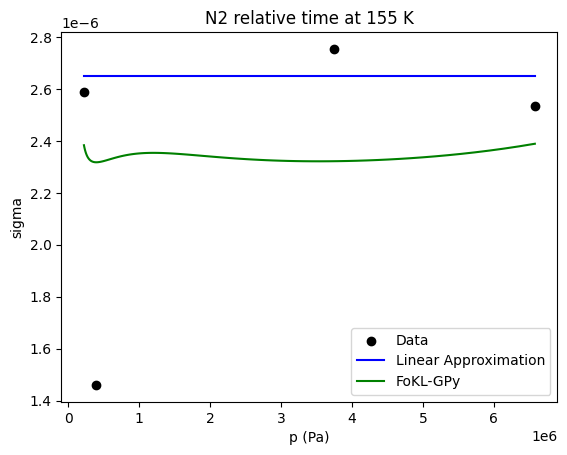

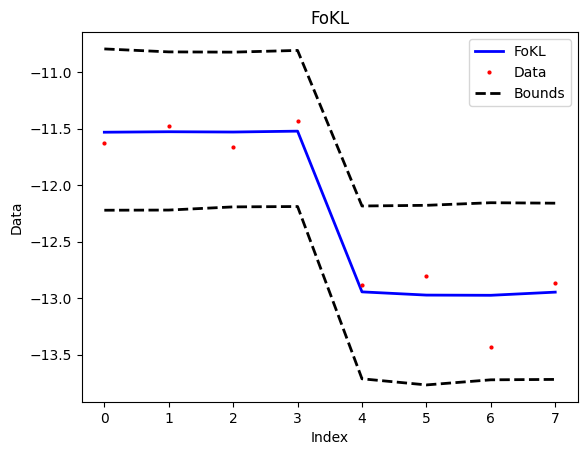

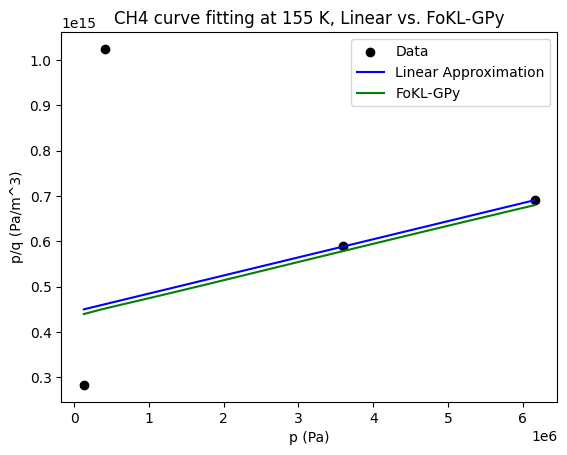

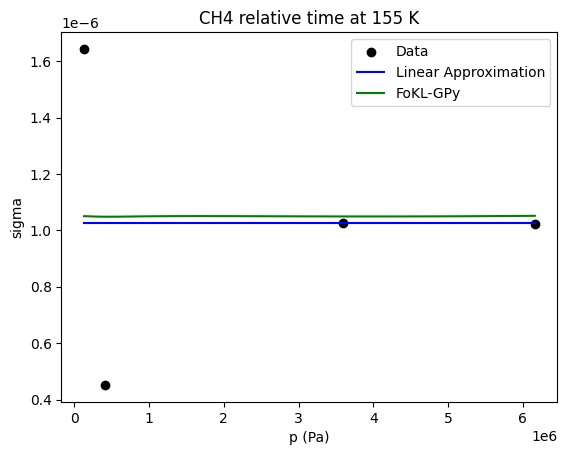

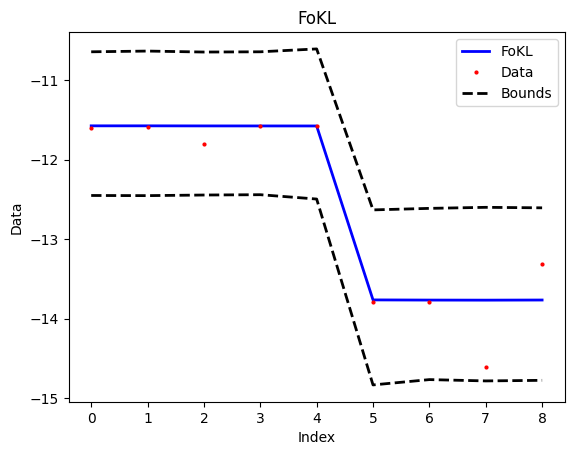

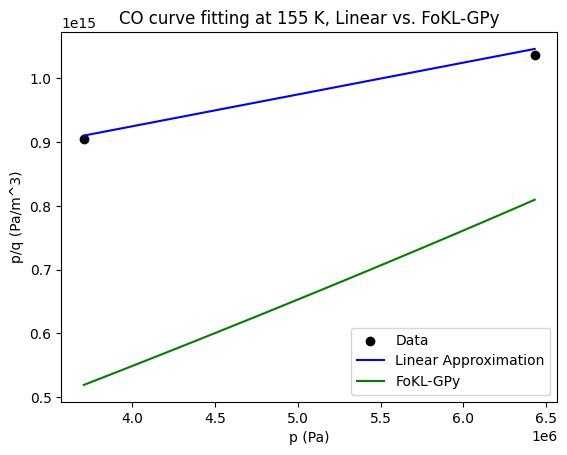

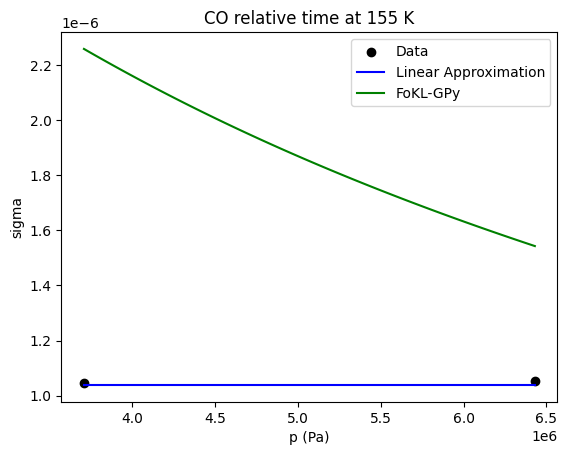

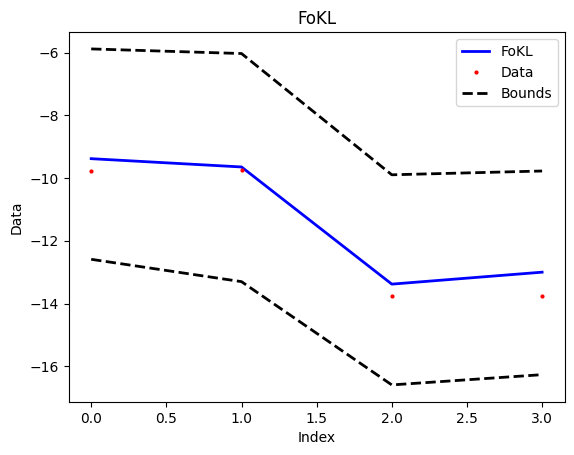

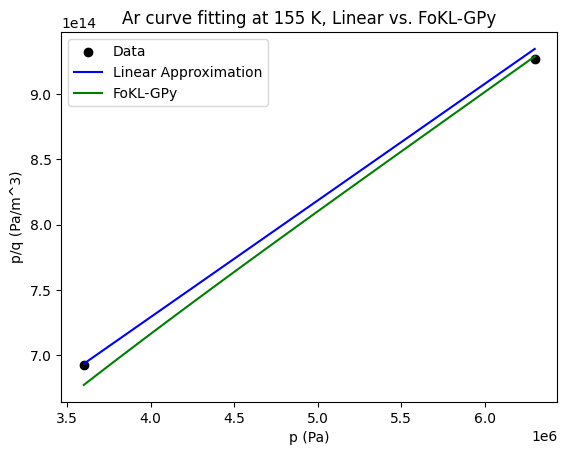

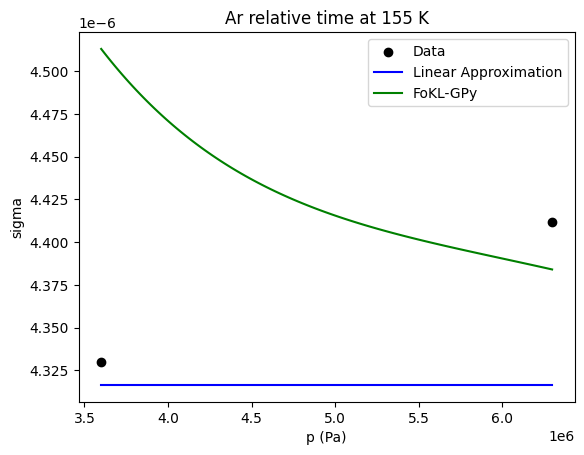

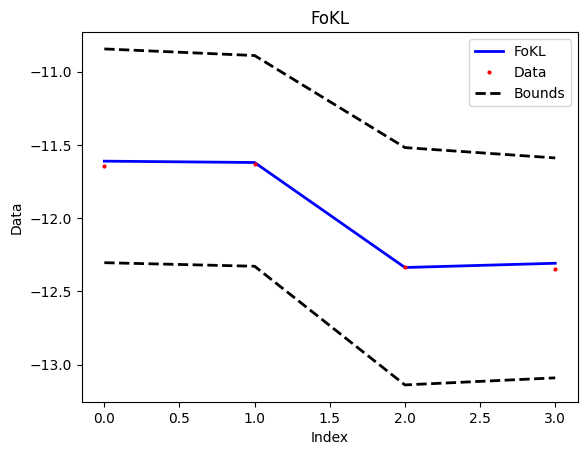

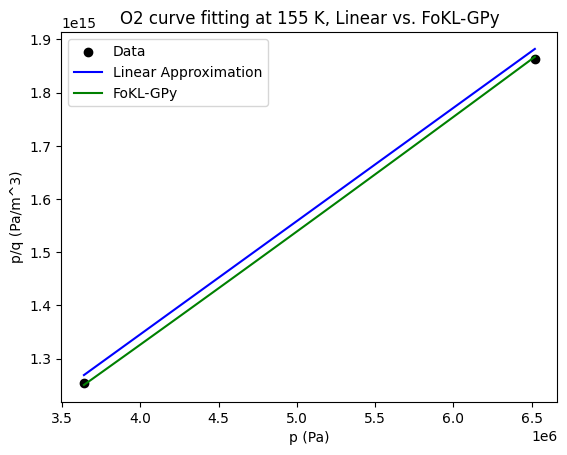

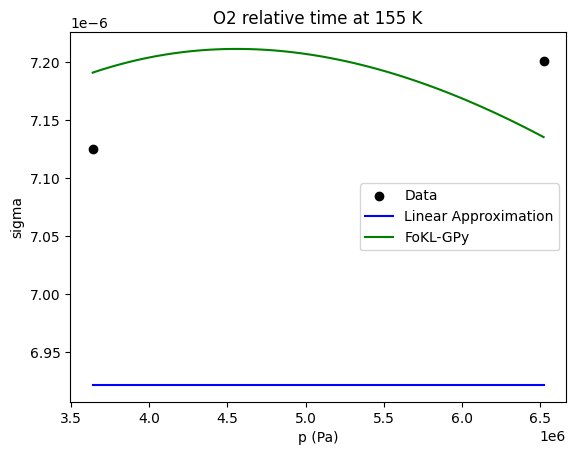

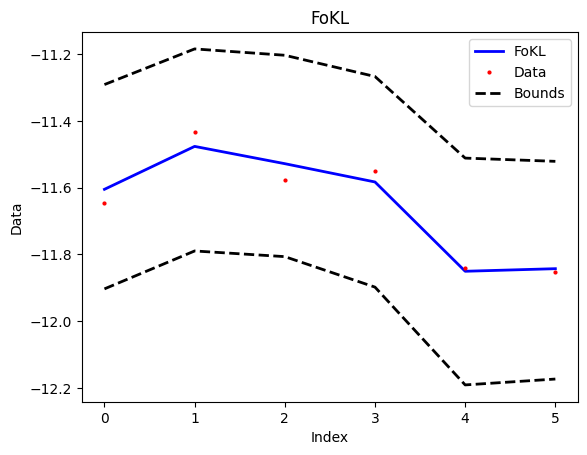

In [ ]:
T_cutoff = {'N2': 4, 'CH4': 5, 'CO': 2, 'Ar': 2, 'O2': 4}  # 90 below, 155 above
res = 100

for T_plt in [90, 155]:
    i = 0
    for gas in gases:
        
        # Grab only values for 155 K:
        if T_plt == 90:
            p_plt = p[gas][:T_cutoff[gas]]
            q_plt = q[gas][:T_cutoff[gas]]
            qmax_plt = qmax[gas][:T_cutoff[gas]]
            a_plt = a[gas][:T_cutoff[gas]]
        elif T_plt == 155:
            p_plt = p[gas][T_cutoff[gas]::]
            q_plt = q[gas][T_cutoff[gas]::]
            qmax_plt = qmax[gas][T_cutoff[gas]::]
            a_plt = a[gas][T_cutoff[gas]::]

        # Get FoKL-GPy model to p/q and p:
        if T_plt == 90:
            inputs_plt = models[i].inputs[:T_cutoff[gas], :]  # normalized model inputs
        elif T_plt == 155:
            inputs_plt = models[i].inputs[T_cutoff[gas]::, :]  # normalized model inputs
        inputs_plt = np.array([np.linspace(inputs_plt[0, 0], inputs_plt[-1, 0], res), np.linspace(inputs_plt[0, 1], inputs_plt[-1, 1], res)]).T  # increase resolution of FoKL inputs
        Delta_plt = models[i].evaluate(inputs_plt)
        sigma_plt = np.exp(Delta_plt)
        p_plt_fokl = np.exp(inputs_plt[:, 1] * (models[i].normalize[1][1] - models[i].normalize[1][0]) + models[i].normalize[1][0])  # denormalize, then exp()
        mu_plt = p_plt_fokl /np.sqrt(2 * np.pi * M[gas] * R * T_plt)
        q_plt_fokl = sigma_plt * qmax_plt[0] * mu_plt / (1 + sigma_plt * mu_plt)  # qmax is constant so use scalar not vector

        # Plot:
        p_plt_linear = np.linspace(p_plt[0], p_plt[-1], 2)
        plt.figure()
        plt.scatter(p_plt, p_plt / q_plt, color='k')  # experimental measurements
        plt.plot(p_plt_linear, p_plt_linear / qmax_plt[0] + 1 / (a_plt[0] * qmax_plt[0]), color='b')  # linear fit (from Langmuir, mx+b --> p/b + 1/(ab))
        plt.plot(p_plt_fokl, p_plt_fokl / q_plt_fokl, color='g')  # FoKL-GPy
        
        # Format:
        plt.title(f"{gas} curve fitting at {T_plt} K, Linear vs. FoKL-GPy")
        plt.xlabel("p (Pa)")
        plt.ylabel("p/q (Pa/m^3)")
        plt.legend(['Data', 'Linear Approximation', 'FoKL-GPy'])

        # ---------------------------

        # Plot sigma vs. p at T:

            #   a p = sigma mu
                #   sigma = a p / mu = a sqrt(2 pi M R T)  # linear
            #   q = a b p / (1 + a p)
                #   q + q a p = a b p
                #   a (b p - q p) = q
                #   a = q / (p * (b - q))
                #   sigma = (q / (p * (b - q))) sqrt(2 pi M R T)
                #   sigma = q sqrt(2 pi M R T) / (p * (b - q))  # experimental measurements, assuming b=qmax is known

        sigma_linear = a_plt[0] * np.sqrt(2 * np.pi * M[gas] * R * T_plt)
        sigma_experimental = q_plt * np.sqrt(2 * np.pi * M[gas] * R * T_plt) / (p_plt * (qmax_plt[0] - q_plt))

        plt.figure()
        plt.scatter(p_plt, sigma_experimental, color='k')  # experimental measurements
        plt.plot([p_plt[0], p_plt[-1]], [sigma_linear, sigma_linear], color='b')  # linear fit (constant value)
        plt.plot(p_plt_fokl, sigma_plt, color='g')  # FoKL-GPy

        # Format:
        plt.title(f"{gas} relative time at {T_plt} K")
        plt.xlabel("p (Pa)")
        plt.ylabel("sigma")
        plt.legend(['Data', 'Linear Approximation', 'FoKL-GPy'])

        # ---------------------------

        # Plot ln(sigma) vs. p at T (i.e., validation plot):

        models[i].coverage3(plot=True)

        # RTW: CREATE v0.4 AND LEAVE THESE PLOTS
        # - TRAIN SEPARATE MODELS ON T ... SO EFFECTIVELY MAKE v0.4 ONLY 90K (likely with focus on O2 in sharing results)
        # - FUTURE WORK MAY TRAIN ON MULTIPLE T, BUT MORE DATA IS LIKELY NEEDED BASED ON RESULTS HERE

        i += 1



Plot $\sigma_1$:

Convert to Pyomo:

In [ ]:
Deltas = []
for gas in gases:
    Deltas.append(f"{gas}_Delta")  # variable name of Delta per gas in Pyomo

m = fokl_to_pyomo.fokl_to_pyomo(models, [['inv_T', 'ln_p'], ['inv_T', 'ln_p'], ['inv_T', 'ln_p'], ['inv_T', 'ln_p'], ['inv_T', 'ln_p']], Deltas, truescale=True, draws=2)  # Pyomo model

Expand upon Pyomo model:

1. $\sigma_1 = \exp(\Delta)$
2. $\theta_1 = \frac{\sigma_1 \mu}{1 + \sigma_1 \mu}$

In [8]:
m.T = pyo.Var(within=pyo.NonNegativeReals, bounds=[90, 155], initialize=90.0)
m.p = pyo.Var(within=pyo.NonNegativeReals, bounds=np.exp(m.ln_p.bounds).tolist(), initialize=np.exp(m.ln_p.bounds[0]))

def eq1(m, i):
    return m.component(f"{gas}_sigma1")[i] == exp(m.component(f"{gas}_Delta")[i])

def eq2(m, i):
    return m.component(f"{gas}_theta1")[i] == m.component(f"{gas}_sigma1")[i] * m.component(f"{gas}_mu") / (1 + m.component(f"{gas}_sigma1")[i] * m.component(f"{gas}_mu"))

im = 0  # needed to index GP (i.e., model) since multiple draws leads to multiple equations in order to preserve Bayesian statistics; f"GP{im}_scenario" created in 'fokl_to_pyomo'
for gas in gases:

    # Define variables, constant across scenarios:
    for var in ['mu']:
        m.add_component(f"{gas}_{var}", pyo.Var(within=pyo.NonNegativeReals, initialize=0.0))
    
    # Define variables per Delta scenarios (i.e., variables that benefit from including Bayesian statistics from multiple draws):
    for var in ['sigma1', 'theta1']:
        m.add_component(f"{gas}_{var}", pyo.Var(m.component(f"GP{im}_scenarios"), within=pyo.NonNegativeReals, initialize=0.0))  # create var for each scenario
    
    # Define constraints:
    m.add_component(f"{gas}_eq1", pyo.Constraint(m.component(f"GP{im}_scenarios"), rule=eq1))  # FoKL model to relative life, sigma1 = exp(Delta)
    m.add_component(f"{gas}_eq2", pyo.Constraint(m.component(f"GP{im}_scenarios"), rule=eq2))  # Langmuir isotherm, theta1 = sigma1 * mu / (1 + sigma1 * mu)

    im += 1

Now, the Pyomo model is ready for any additional chemistry constraints or other additions.

To compare against the benchmark data, $\theta_1$ will be evaluated in Pyomo at the $(T, p)$ values then converted to $q_{cal}$ values by multiplying by $b$.

In [10]:
solver = pyo.SolverFactory('multistart')

theta1 = {'N2': [], 'CH4': [], 'CO': [], 'Ar': [], 'O2': []}
q_GP = {}
im = 0
for gas in gases:
    for i in range(data[gas].shape[0]):
        # m.obj = pyo.Objective(expr=abs(m.T - T[gas][i]) + abs(m.p - p[gas][i]), sense=pyo.minimize)  # set objective for solver to optimize
        m.obj = pyo.Objective(expr=sum(m.component(f"{gas}_sigma1")[0] for gas in gases), sense=pyo.minimize)  # set objective for solver to optimize

        # m.T.fix(T[gas][i])
        # m.p.fix(p[gas][i])

        solver.solve(m, solver='ipopt', suppress_unbounded_warning=True)

        theta1[gas].append(sum(m.component(f"{gas}_theta1")[i] for i in m.component(f"GP{im}_scenarios")) / len(m.component(f"GP{im}_scenarios")))  # average of GP
    
    theta1[gas] = np.array(theta1[gas])
    q_GP.update({gas: theta1[gas] * qmax[gas]})
    im += 1

ipopt


ApplicationError: No executable found for solver 'ipopt'

Print results, **and make table**:

In [ ]:
for gas in gases:
    print(f"\nResults for {gas}...")
    print(f"\nObserved:")
    print(q[gas])
    print(f"\nLinear model:")
    print(qcal[gas])
    print(f"\nFoKL-GPy model:")
    print(q_GP[gas])

**Plots of $\frac{p}{q}$ vs. $p$ (or whatever linear fit is):**

In [ ]:
for gas in gases:
    scatter()  # raw measurements
    plot()  # linear fit
    plot()  # FoKL-GPy



<c id=1> [1] <c/> [THE ADSORPTION OF GASES ON PLANE SURFACES OF GLASS, MICA AND PLATINUM. <br>
&emsp;&nbsp; Irving Langmuir <br>
&emsp;&nbsp; Journal of the American Chemical Society 1918 40 (9), 1361-1403 <br>
&emsp;&nbsp; DOI: 10.1021/ja02242a004](https://pubs.acs.org/doi/epdf/10.1021/ja02242a004#) <br>